<a href="https://colab.research.google.com/github/Mishana2261426/Predictive-Analytics-for-Car-Selling-Price-Prediction/blob/main/Predictive_Analytics_Car_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
DATA_PATH = "used_cars_dataset.csv"
df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(10)

Shape: (1000, 9)


,make,model,year,mileage,engine_size,fuel_type,transmission,owners,selling_price
0,Honda,Model_A,2022,145600,3.0,Hybrid,Manual,2,29003.0
1,Ford,Model_C,2019,229884,2.6,Diesel,Manual,3,17472.0
2,Audi,Model_D,2006,186172,3.6,Hybrid,Manual,2,19181.0
3,Hyundai,Model_D,2014,114869,3.0,Petrol,Automatic,1,19531.0
4,Honda,Model_C,2016,144251,2.6,Diesel,Automatic,3,26131.0
5,Nissan,Model_D,2021,53781,3.5,Diesel,Manual,2,32705.0
6,Mercedes,Model_D,2012,191339,2.8,Petrol,Automatic,1,20007.0
7,Honda,Model_D,2015,218451,1.9,Hybrid,Automatic,1,14133.0
8,Audi,Model_D,2007,160024,1.6,Diesel,Manual,3,13144.0
9,Hyundai,Model_D,2010,58798,1.5,Diesel,Manual,1,14068.0


In [3]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           1000 non-null   object 
 1   model          1000 non-null   object 
 2   year           1000 non-null   int64  
 3   mileage        1000 non-null   int64  
 4   engine_size    1000 non-null   float64
 5   fuel_type      1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owners         1000 non-null   int64  
 8   selling_price  1000 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [4]:
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing

,0


In [5]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
make,1000,10,Toyota,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,1000,4,Model_A,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,1000.0,NaN,NaN,NaN,2013.367,5.201477,2005.0,2009.0,2013.0,2018.0,2022.0
mileage,1000.0,NaN,NaN,NaN,129393.065,71471.660633,5138.0,66660.75,133530.0,191384.5,249576.0
engine_size,1000.0,NaN,NaN,NaN,2.5624,0.846713,1.0,1.9,2.6,3.3,4.0
fuel_type,1000,3,Hybrid,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,1000,2,Manual,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owners,1000.0,NaN,NaN,NaN,1.97,0.803583,1.0,1.0,2.0,3.0,3.0
selling_price,1000.0,NaN,NaN,NaN,20909.93,7209.233779,3090.0,15622.0,20438.5,25964.25,41390.0


In [6]:
df["mileage"] = pd.to_numeric(df["mileage"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["engine_size"] = pd.to_numeric(df["engine_size"], errors="coerce")
df["owners"] = pd.to_numeric(df["owners"], errors="coerce")

In [7]:
df["mileage"].fillna(df["mileage"].median(), inplace=True)
df["engine_size"].fillna(df["engine_size"].median(), inplace=True)

for col in ["fuel_type", "transmission", "make", "model"]:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [8]:
Q1 = df["selling_price"].quantile(0.25)
Q3 = df["selling_price"].quantile(0.75)
IQR = Q3 - Q1

df = df[(df["selling_price"] >= Q1 - 1.5 * IQR) &
        (df["selling_price"] <= Q3 + 1.5 * IQR)]


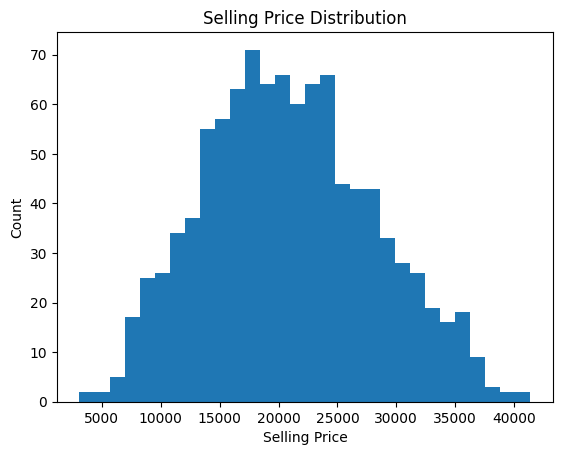

In [9]:
plt.hist(df["selling_price"], bins=30)
plt.title("Selling Price Distribution")
plt.xlabel("Selling Price")
plt.ylabel("Count")
plt.show()

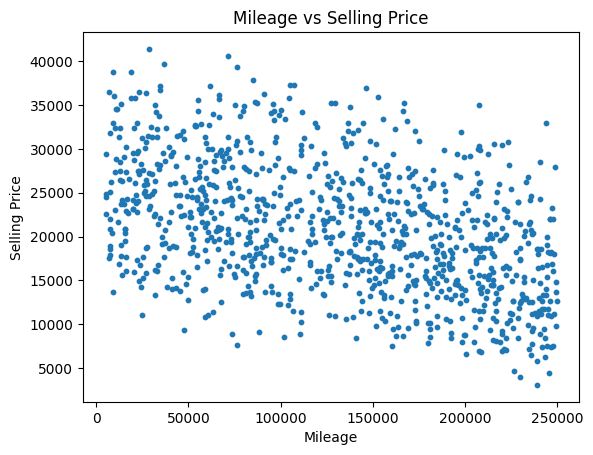

In [10]:
plt.scatter(df["mileage"], df["selling_price"], s=10)
plt.title("Mileage vs Selling Price")
plt.xlabel("Mileage")
plt.ylabel("Selling Price")
plt.show()

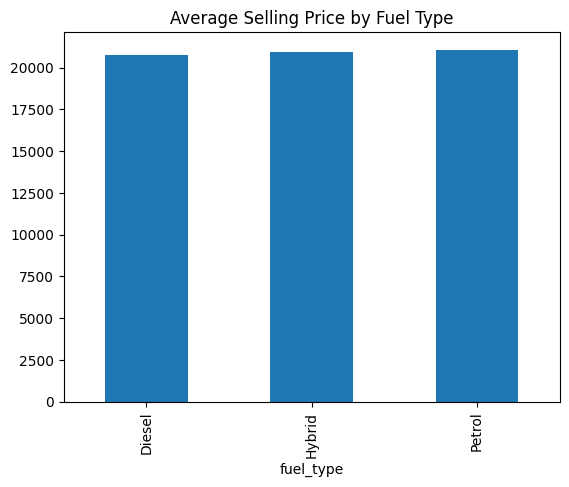

In [11]:
df.groupby("fuel_type")["selling_price"].mean().plot(kind="bar")
plt.title("Average Selling Price by Fuel Type")
plt.show()

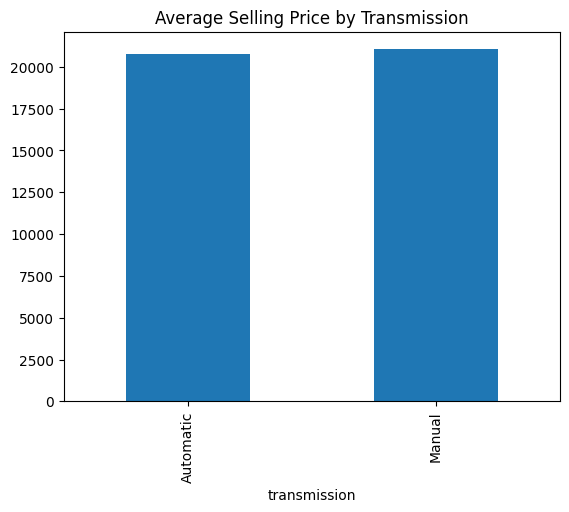

In [12]:
df.groupby("transmission")["selling_price"].mean().plot(kind="bar")
plt.title("Average Selling Price by Transmission")
plt.show()

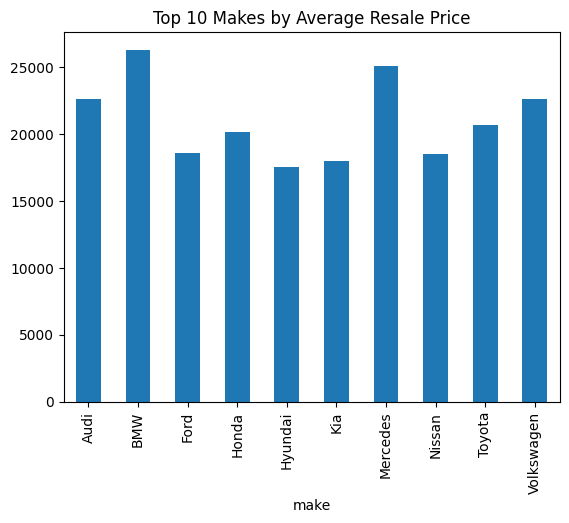

In [13]:
top_makes = df["make"].value_counts().head(10).index
df[df["make"].isin(top_makes)].groupby("make")["selling_price"]
.mean().plot(kind="bar")
plt.title("Top 10 Makes by Average Resale Price")
plt.show()

In [15]:
median_price = df["selling_price"].median()

df["value_class"] = (df["selling_price"] > median_price)
.astype(int)

print("Median selling_price:", median_price)
print("\nClass distribution:")
print(df["value_class"].value_counts())
df[["selling_price", "value_class"]].head(10)

Median selling_price: 20438.5

Class distribution:
value_class
1    500
0    500
Name: count, dtype: int64


,selling_price,value_class
0,29003.0,1
1,17472.0,0
2,19181.0,0
3,19531.0,0
4,26131.0,1
5,32705.0,1
6,20007.0,0
7,14133.0,0
8,13144.0,0
9,14068.0,0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

CURRENT_YEAR = 2026
df["age"] = CURRENT_YEAR - df["year"]

feature_cols = [
    "age", "year", "mileage", "engine_size", "owners",
    "fuel_type", "transmission", "make", "model"
]
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].copy()
y = df["value_class"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

numeric_features = [c for c in X.columns if c in ["age", "year", "mileage",
                                                  "engine_size", "owners"]]
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

log_reg.fit(X_train, y_train)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Train shape: (700, 9)
Test shape: (300, 9)
Numeric features: ['age', 'year', 'mileage', 'engine_size', 'owners']
Categorical features: ['fuel_type', 'transmission', 'make', 'model']


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))

              precision    recall  f1-score   support

           0      0.878     0.913     0.895       150
           1      0.910     0.873     0.891       150

    accuracy                          0.893       300
   macro avg      0.894     0.893     0.893       300
weighted avg      0.894     0.893     0.893       300

ROC-AUC: 0.976


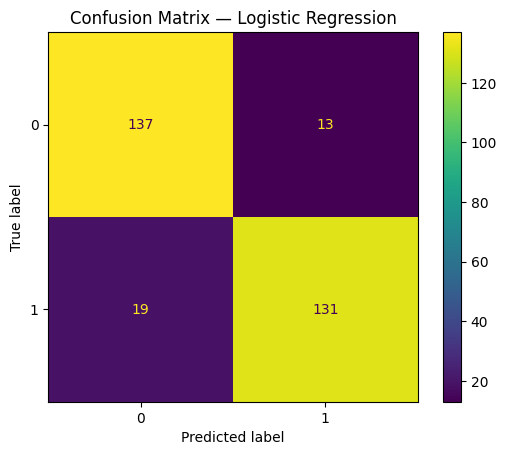

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

In [19]:
preprocess_fitted = log_reg.named_steps["preprocess"]
ohe = preprocess_fitted.named_transformers_["cat"].named_steps["onehot"]

cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

coefs = log_reg.named_steps["model"].coef_[0]

coef_table = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

coef_table.head(20)

,feature,coef,abs_coef
2,mileage,-2.144144,2.144144
15,make_Kia,-2.032720,2.032720
16,make_Mercedes,1.931474,1.931474
0,age,-1.765017,1.765017
1,year,1.765017,1.765017
14,make_Hyundai,-1.554239,1.554239
3,engine_size,1.482728,1.482728
11,make_BMW,1.389459,1.389459
10,make_Audi,1.378576,1.378576
12,make_Ford,-0.833544,0.833544


In [20]:
top_positive = coef_table.sort_values("coef", ascending=False).head(10)
top_negative = coef_table.sort_values("coef", ascending=True).head(10)

top_positive, top_negative

(                feature      coef  abs_coef
 16        make_Mercedes  1.931474  1.931474
 1                  year  1.765017  1.765017
 3           engine_size  1.482728  1.482728
 11             make_BMW  1.389459  1.389459
 10            make_Audi  1.378576  1.378576
 19      make_Volkswagen  0.773397  0.773397
 20        model_Model_A  0.255940  0.255940
 22        model_Model_C  0.166383  0.166383
 6      fuel_type_Hybrid  0.110130  0.110130
 9   transmission_Manual  0.050228  0.050228,
              feature      coef  abs_coef
 2            mileage -2.144144  2.144144
 15          make_Kia -2.032720  2.032720
 0                age -1.765017  1.765017
 14      make_Hyundai -1.554239  1.554239
 12         make_Ford -0.833544  0.833544
 17       make_Nissan -0.697353  0.697353
 13        make_Honda -0.357800  0.357800
 23     model_Model_D -0.320519  0.320519
 5   fuel_type_Diesel -0.134728  0.134728
 21     model_Model_B -0.121360  0.121360)

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

cluster_features = ["age", "mileage", "engine_size", "selling_price"]

X_cluster = df[cluster_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

print("Cluster sizes:")
print(df["cluster"].value_counts().sort_index())


Cluster sizes:
cluster
0    300
1    302
2    398
Name: count, dtype: int64
